In [1]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.gridspec import GridSpec
import os
import cv2
from utils.notebook_utils import process_image, softmax, pixel_uncertainty
import pickle as pkl
import matplotlib
from munch import munchify
import yaml

In [2]:
font = {'family' : 'sans serif',
        'size'   : 18}
matplotlib.rc('font', **font)

In [ ]:
with open('paths.yaml', 'r') as file0:
        cfg_paths = munchify(yaml.load(file0, Loader=yaml.FullLoader))
        file0.close()

Load Inputs and Ground Truth

In [3]:
root = cfg_paths.FIVES
split = 'test'
config_suffix = 'all_patches'

In [4]:
# Load Images, GT, Mean Prediction, Uncertainty Map
split_x = sorted(glob(os.path.join(root, split + '/Original/*')))
split_y = sorted(glob(os.path.join(root, split + '/Ground truth/*')))

In [5]:
# select indices
img_idx = 95
x_path = split_x[img_idx]
y_path = split_y[img_idx]

gt = []

In [6]:
image = cv2.imread(x_path, cv2.IMREAD_COLOR) ## (512, 512, 3)
# image = clahe_equalized(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (512,512))

mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
mask = cv2.resize(mask, (512,512)) # interpolation =  INTER_NEAREST

# read and process image 
# image, mask = read_image(x, y, size=512, pre_process=True)
x, y = process_image(image, mask)

Load Predictions

In [7]:
with open('cache/ensemble_dict.pkl', 'rb') as file2:
    ensemble_dict = pkl.load(file2)
    file2.close()

In [8]:
ensemble_dict['mean logits'] = np.array(ensemble_dict['logits']).mean(axis=0)
ensemble_dict['mean predictions'] = softmax(np.array(ensemble_dict['logits'])).mean(axis=0)

predicted_logits_arr = np.array(ensemble_dict['logits'])
predictions_arr = softmax(predicted_logits_arr) # not calibrated yet -- happens later

In [9]:
entropy_maps = []

for i in range(predictions_arr.shape[1]):
    entropy_maps.append(pixel_uncertainty(predictions_arr[:, i,: ,:], 'entropy'))

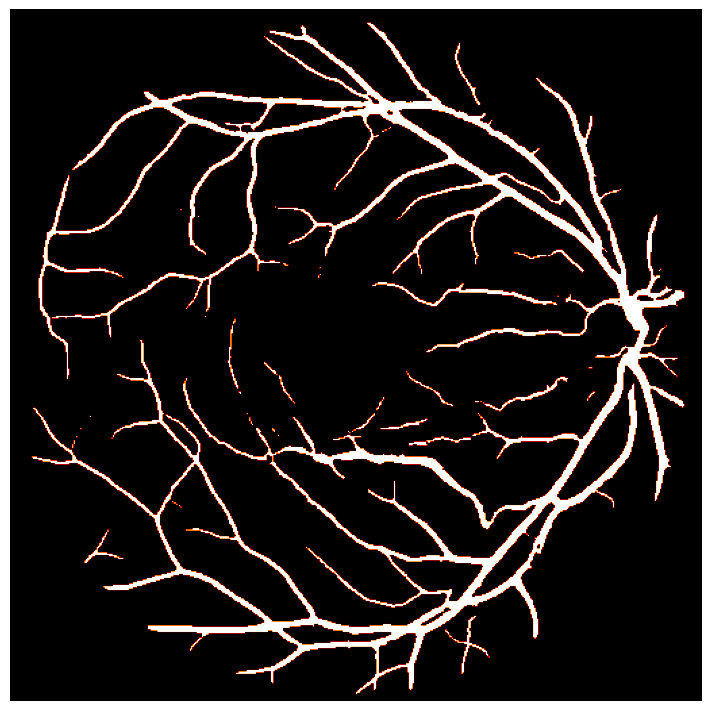

In [10]:
fig, ax = plt.subplots(layout='constrained', figsize=(7,7))
ax.axis('off')

plt.imshow(ensemble_dict['mean predictions'][img_idx] >= 0.5, cmap='gist_heat')

#fig.savefig('fig/overview_prediction.png', dpi=150, bbox_inches='tight', pad_inches=0)

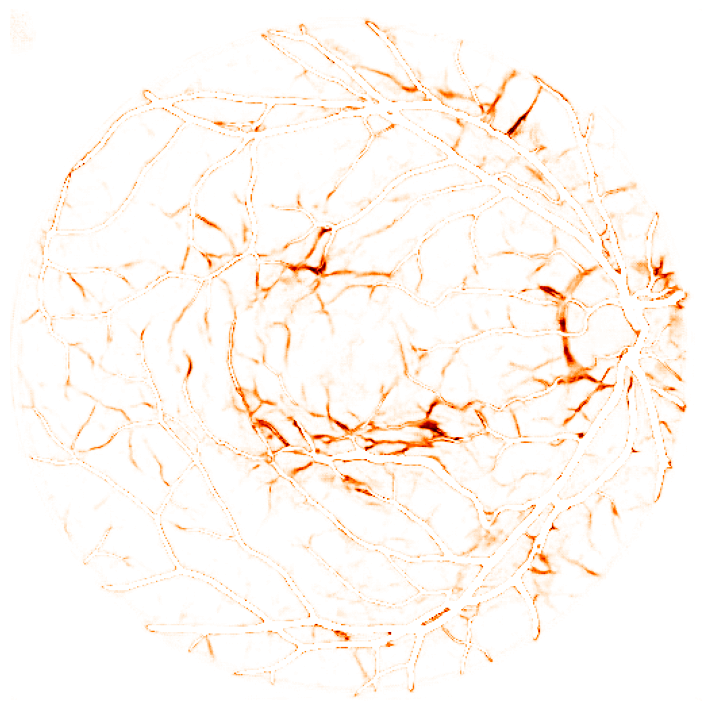

In [11]:
fig, ax = plt.subplots(layout='constrained', figsize=(7,7))
ax.axis('off')

plt.imshow(entropy_maps[img_idx], cmap='gist_heat')
#fig.savefig('fig/overview_uncertainty_map.png', dpi=150, bbox_inches='tight', pad_inches=0)

Example Images

In [12]:
# select indices based on increase in DSC and frac of positive
with open('cache/' + config_suffix + '_oracle_results.pkl', 'rb') as file2:
    oracle_results = pkl.load(file2)
    file2.close()
    
oracle_true = np.array([img_dict['true dsc curve'] for img_dict in oracle_results])
oracle_est = np.array([img_dict['est dsc curve'] for img_dict in oracle_results])

In [15]:
img_idx = [12, 136, 153, 95, 100]
images = []
gt =[]

In [16]:
for idx in img_idx:
    x_path = split_x[idx]
    y_path = split_y[idx]

    image = cv2.imread(x_path, cv2.IMREAD_COLOR) ## (512, 512, 3)
    # image = clahe_equalized(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (512,512))

    mask = cv2.imread(y_path, cv2.IMREAD_GRAYSCALE)  ## (512, 512)
    mask = cv2.resize(mask, (512,512)) # interpolation =  INTER_NEAREST

    # read and process image 
    # image, mask = read_image(x, y, size=512, pre_process=True)
    x, y = process_image(image, mask)
    images.append(x.squeeze().permute(1,2,0))
    gt.append(y.squeeze())

In [17]:
[images.append(ensemble_dict['mean predictions'][img_idx][i]) for i in range(ensemble_dict['mean predictions'][img_idx].shape[0])];

In [18]:
[images.append(-entropy_maps[idx]) for idx in img_idx];

In [19]:
[images.append(maske) for maske in gt];

Obtain Patch Coordinates

In [20]:
with open('cache/' + config_suffix + '_estimation_info.pkl', 'rb') as file:
    estimation_info = pkl.load(file) # estimates are uncalibrated here!
    file.close()

In [21]:
# Compute reference points
patch1_refs = []
patch2_refs = []

def get_ref_points(mask1, mask2):
    positives_1 = np.where(~mask1)
    patch_1 = (positives_1[0][0], positives_1[1][0])
    
    # Ignore what has been positive before
    mask2_post = np.logical_xor(~mask2, ~mask1)
    positives_2 = np.where(mask2_post)
    patch_2 = (positives_2[0][0], positives_2[1][0])

    return patch_1, patch_2

for idx in img_idx:
    p1_c, p2_c = get_ref_points(estimation_info[idx]['masks'][1], estimation_info[idx]['masks'][2])
    patch1_refs.append(p1_c)
    patch2_refs.append(p2_c)

In [22]:
patch1 = [patch1_refs[i] for j in range(4) for i in range(len(patch1_refs))]
patch2 = [patch2_refs[i] for j in range(4) for i in range(len(patch2_refs))]

patch_refs = []
for p1, p2 in zip(patch1, patch2):
    patch_refs.append((p1, p2))

Store patches separately

In [26]:
square_size = 81

patch_imgs = []

for img, patch_c in zip(images, patch_refs):
    patch_imgs.append(img[patch_c[0][0]:patch_c[0][0]+square_size, patch_c[0][1]:patch_c[0][1]+square_size])
    patch_imgs.append(img[patch_c[1][0]:patch_c[1][0]+square_size, patch_c[1][1]:patch_c[1][1]+square_size])


/tmp/ipykernel_17054/110992093.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.savefig('fig/grid_patches_v1.png', dpi=150, bbox_inches='tight')


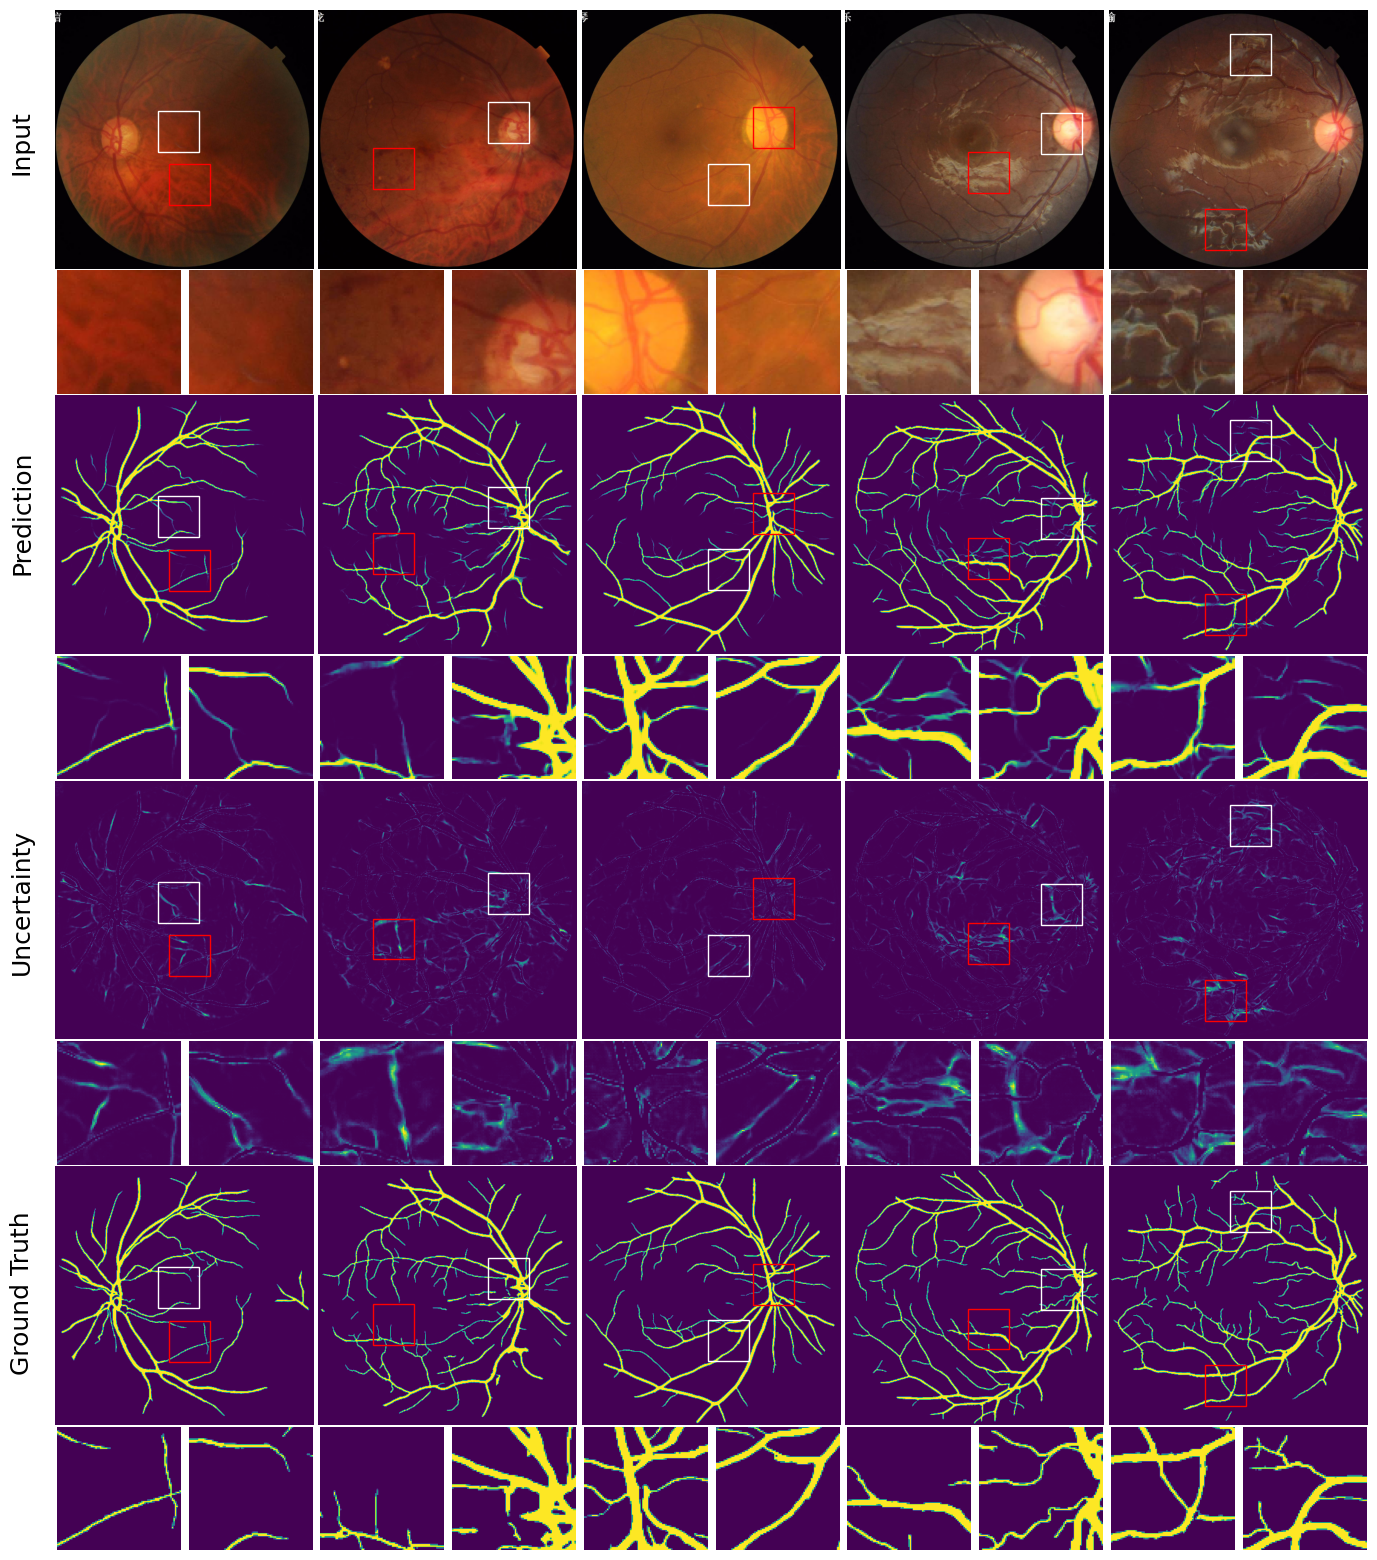

In [27]:
cmap = 'viridis'
fig = plt.figure(layout='tight', figsize=(17,20))

def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.axis('off')


n_grid  = 8 # no rows times 2
m_grid = 10 # no cols times 2
row_heights = np.tile([2.1, 1], np.array(n_grid/2).astype(int))
gs = GridSpec(n_grid, m_grid, hspace=0.01, wspace=0.0, height_ratios=row_heights)
axes_fullsize = []
axes_patches = []

## Modify GridSpec to create axes in the appropriate size and orientation
#
for i in range(np.array(n_grid/2).astype(int)):
    for j in range(np.array(m_grid/2).astype(int)):

        axes_fullsize.append(fig.add_subplot(gs[2*i, 2*j:(2*j+2)]))

for i in range(np.array(n_grid/2).astype(int)):
    for j in range(m_grid):

        axes_patches.append(fig.add_subplot(gs[2*i + 1, j])) 

# Fill in Images
for img_count, ax_fullsize in enumerate(axes_fullsize):
    ax_fullsize.axis('off')
    ax_fullsize.imshow(images[img_count], cmap=cmap)
    # need to define artist everytime again
    square1 = patches.Rectangle((patch_refs[img_count][0][1], patch_refs[img_count][0][0]), square_size, square_size, edgecolor='red', facecolor='none')
    square2 = patches.Rectangle((patch_refs[img_count][1][1], patch_refs[img_count][1][0]), square_size, square_size, edgecolor='white', facecolor='none')

    ax_fullsize.add_patch(square1)
    ax_fullsize.add_patch(square2)


for k, ax_patch in enumerate(axes_patches):
    if k % 2 == 0:
        ax_patch.imshow(patch_imgs[k], cmap=cmap)
    else:
        ax_patch.imshow(patch_imgs[k], cmap=cmap)

format_axes(fig)

fig.text(0.1, 0.8, 'Input', rotation=90)
fig.text(0.1, 0.6, 'Prediction', rotation=90)
fig.text(0.1, 0.4, 'Uncertainty', rotation=90)
fig.text(0.1, 0.2, 'Ground Truth', rotation=90)
fig.savefig('fig/grid_patches_v1.png', dpi=150, bbox_inches='tight')